# Long-range correlation and fractal dynamics in C. elegans: changes with aging and stress

## Libraries and Settings

In [1]:
#sets the notebook width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [39]:
import sys
import os
import pathlib
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy.stats import norm
from scipy import stats
import matplotlib.mlab as mlab
import statsmodels.stats.multitest as smm
import matplotlib.ticker as plticker
import random
from scipy import optimize
from matplotlib import ticker
from matplotlib import gridspec
import warnings

warnings.filterwarnings('ignore')

In [3]:
# Locals
from modules.functions import *

In [4]:
plt.rcParams['xtick.major.pad'] = 10
plt.rcParams['xtick.minor.pad'] = 10
plt.rcParams['ytick.major.pad'] = 10
plt.rcParams['ytick.minor.pad'] = 10
plt.rcParams['xtick.direction']="in"
plt.rcParams['ytick.direction']="in"
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True

# Functions

In [13]:
def increase_font(ax, fontsize=18):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)

def datainfo():
    print("Aging data set summary")
    print("\n")
    summary=[]
    for age in [1,2,3,4,5,6]:
        sample_dir=pathlib.Path('../data/age/{}'.format(age))
        tracks=[i for i in sample_dir.glob('*')]
        summary.append([age,len(tracks)])
        
    print(pd.DataFrame(summary,columns=["Age","# tracks"]))
     
    print("\n")
    summary=[]
    for t in [15,20,25]:
        sample_dir=pathlib.Path('../data/temperature/{}'.format(t))
        tracks=[i for i in sample_dir.glob('*')]
        summary.append([t,len(tracks)])
        
    print("Temperature data set summary\n")
        
    print(pd.DataFrame(summary,columns=["Temperature","# tracks"]))
    

def read_tracks(tracks):
    df_tracks=[]
    for track in tracks:
        df_track=pd.read_csv(str(track), index_col=0)
        df=df_track[df_track.time>=1800] #Select points with time t>30 minutes
        df.sort_values(by='time',inplace=True)
        if len(df)>100:
            df_tracks.append(df)

    len_max=max([len(x) for x in df_tracks])

    df_x=pd.DataFrame()
    for i,df in enumerate(df_tracks):
        x=np.array(df["x"])
        x=np.array(x-x[0])
        x0=np.zeros(len_max-len(x))
        x=np.concatenate((x,x0), axis=0)
        df_x[i]=x


    df_y=pd.DataFrame()
    for i,df in enumerate(df_tracks):
        y=np.array(df["y"])
        y=np.array(y-y[0])
        y0=np.zeros(len_max-len(y))
        y=np.concatenate((y,y0), axis=0)
        df_y[i]=y
    return df_x,df_y

def msd(df_x,df_y):
    variance=[np.nanvar(df_x.T[t])+np.nanvar(df_y.T[t]) for t in range(0,len(df_y))]
    return variance

def msd_by_age(age):
    sample_dir=pathlib.Path('../data/age/{}'.format(age))
    tracks=[i for i in sample_dir.glob('*')]
    
    df_x,df_y=read_tracks(tracks)
        
    variance=msd(df_x,df_y)
    
    var_df=pd.DataFrame(np.transpose([np.arange(0,len(df_y))/5,variance]),columns=["time","variance"])
    var_df.to_csv("../results/msd_age-{}.csv".format(age))


def piecewise_linear(x, x0, y0, k1):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:y0])

def line(x, a, b):
    return a * x + b

def winm(x, y, nw):
    xw = []
    yw = []
    step = (max(x) - min(x)) / nw
    lw = [min(x) + step * i for i in range(0, nw)]
    for i in range(0, len(lw) - 1):
        if len(y[x > lw[i]][x[x > lw[i]] < lw[i + 1]]) > 0:
            xw.append(np.mean(x[x > lw[i]][x[x > lw[i]] < lw[i + 1]]))
            yw.append(np.mean(y[x > lw[i]][x[x > lw[i]] < lw[i + 1]]))
    return (xw, yw)

def read_dataset(dataset,label):
    """label can be age or temperature, this is, 1,2,3,4,5,6 or 15,20,25"""
    if dataset=="age":
        sample_dir=pathlib.Path('../data/age/{}'.format(label))
    else:
        sample_dir=pathlib.Path('../data/temperature/{}'.format(label))
    tracks=[i for i in sample_dir.glob('*')]
    df_x,df_y=read_tracks(tracks)
    return df_x,df_y

def slope_random_sample(df_x,df_y):
    randomsample=list(np.random.choice(list(df_x.columns),df_x.shape[1]))
    ndf_x=df_x[randomsample]
    ndf_y=df_x[randomsample]

    variance=msd(ndf_x,ndf_y)
    var_df=pd.DataFrame(np.transpose([np.arange(0,len(ndf_y))/5,variance]),
                        columns=["time","variance"])
    y=np.log10(var_df['variance'].tolist()[1:])
    x=np.log10(var_df["time"].tolist()[1:])

    xw, yw=winm(x,y,200)
    xw, yw=np.array(xw), np.array(yw)

    param_bounds=([-np.inf,-np.inf,0],[np.inf,np.inf,2])
    p , pcov = optimize.curve_fit(piecewise_linear, xw[1:], yw[1:],bounds=param_bounds) 
    return(p[-1])
    

# Data summary

In [5]:
datainfo()

Aging data set summary


   Age  # tracks
0    1       244
1    2       190
2    3       162
3    4       198
4    5       224
5    6        66


Temperature data set summary

   Temperature  # tracks
0           15        67
1           20        48
2           25        64


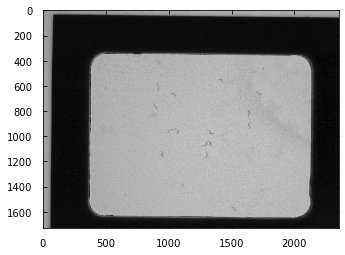

In [61]:
figpath="../data/20151026_132836-copper-15worms-N2-day1-standard-c3600170.png"

import matplotlib.image as mpimg
image = mpimg.imread(figpath)
plt.imshow(image, cmap='gray')

plt.show()


In [67]:
figpath="../data/track.pdf"
from IPython.display import IFrame
IFrame(figpath, width=600, height=400)

# Aging data set

## Mean Square Displacement

In [6]:
age=1
sample_dir=pathlib.Path('../data/age/{}'.format(age))
tracks=[i for i in sample_dir.glob('*')]

In [7]:
df_x,df_y=read_tracks(tracks)
variance=msd(df_x,df_y)

In [8]:
var_df=pd.DataFrame(np.transpose([np.arange(0,len(df_y))/5,variance]),columns=["time","variance"])
var_df.to_csv("../results/msd_age-{}.csv".format(age))
var_df.head()

,time,variance
0,0.0,0.000000
1,0.2,0.000118
2,0.4,0.000722
3,0.6,0.001861
4,0.8,0.003194


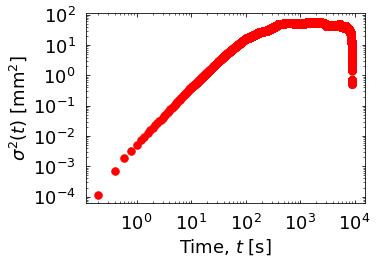

In [9]:
fig, ax = plt.subplots(figsize=(5,3.5))
ax = plt.subplot(111, xlabel="Time, $t$ [s]", 
         ylabel="$\sigma^2(t)$ [mm$^2$]")

ax.loglog(np.arange(0,len(df_y))/5,variance, ".r",markersize=15)

increase_font(ax,fontsize=18)

In [10]:
#for age in [1,2,3,4,5,6]:
#    msd_by_age(age)

In [11]:
msd_aging=pd.DataFrame()
age=1
df=pd.read_csv("../results/msd_age-{}.csv".format(age),index_col=0)
msd_aging['time']=df['time']
for age in [1,2,3,4,5,6]:
    df=pd.read_csv("../results/msd_age-{}.csv".format(age),index_col=0)
    msd_aging[str(age)]=df['variance']

[ 2.24955812  1.6530972   1.70285396]
[ 0.01200987  0.01016612  0.014524  ]


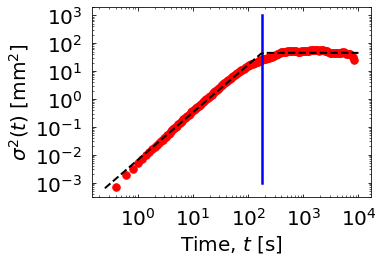

[ 2.52711639  1.45963527  1.59739281]
[ 0.01566148  0.01385582  0.01511838]


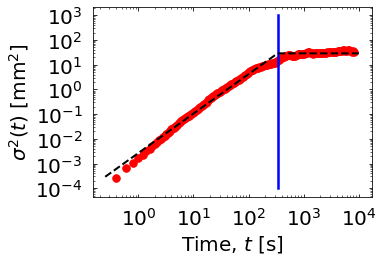

[ 2.41769507  1.5263808   1.69256481]
[ 0.01185721  0.0105962   0.01293123]


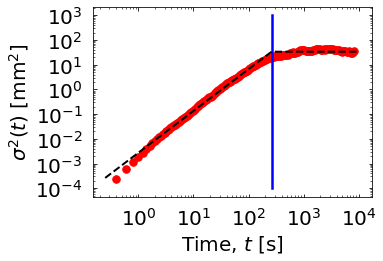

[ 2.31520528  1.69634574  1.65232543]
[ 0.01457774  0.0123266   0.01645663]


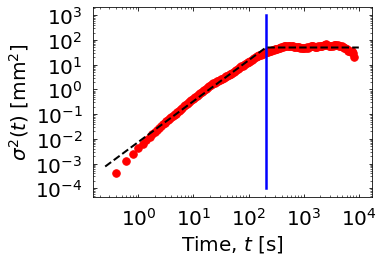

[ 2.36308505  1.63747631  1.67231308]
[ 0.01546792  0.01346711  0.0171887 ]


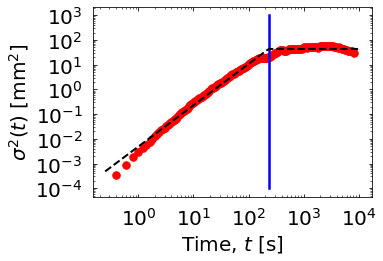

[ 2.41632597  1.6540787   1.61540052]
[ 0.02039047  0.01740241  0.02123729]


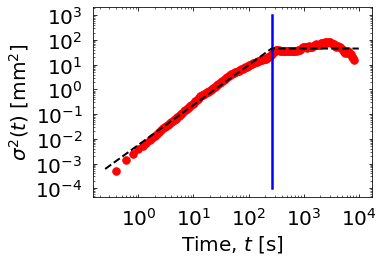

In [12]:
exp=[]
experror=[]
minb=np.array([np.nan,1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])/1000
for i in [1,2,3,4,5,6]:
    y=np.log10(msd_aging[str(i)].tolist()[1:])
    x=np.log10(msd_aging["time"].tolist()[1:])
    
    xw, yw=winm(x,y,200)
    xw2, yw2=winm(x,y,1000)
    xw, yw=np.array(xw), np.array(yw)

    param_bounds=([-np.inf,-np.inf,0],[np.inf,np.inf,2])
    p , pcov = optimize.curve_fit(piecewise_linear, xw[1:], yw[1:],bounds=param_bounds) #x0, y0, k1
    print(p)
    exp.append(p[2])
    experror.append(np.sqrt(np.diag(pcov))[2])

    print(np.sqrt(np.diag(pcov)))
    xd = np.linspace(-0.6, 4, 100)
    fig, ax = plt.subplots(figsize=(5,3.5))
    ax = plt.subplot(111, xlabel="Time, $t$ [s]", 
             ylabel="$\sigma^2(t)$ [mm$^2$]")
    locy = plticker.MultipleLocator(base=1^10) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(locy)
    

    ax.loglog(10**np.array(xw),10**np.array(yw), ".r",markersize=15)
    ax.loglog([10**p[0],10**p[0]],[minb[i],10**3],"-b",linewidth=2.5)
    ax.loglog(10**xd, 10**piecewise_linear(xd, *p),"--k",linewidth=2)

    increase_font(ax,fontsize=20)
    plt.savefig("../results/msd_age_"+str(i)+".pdf",bbox_inches='tight')
    plt.show()

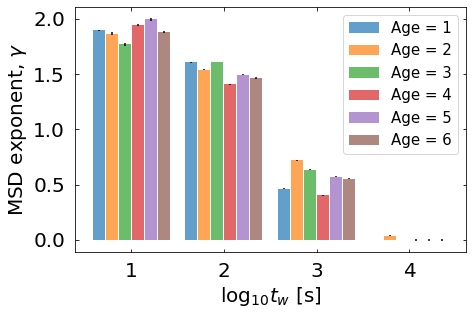

In [13]:
fig, ax = plt.subplots(figsize=(7,4.5))
ax = plt.subplot(111, xlabel="$\log_{10} t_w$ [s]", 
         ylabel="MSD exponent, $\gamma$")

ind = np.arange(4)  # the x locations for the groups
width = 0.13# the width of the bars
ax.set_xticks(ind + 3*(width+0.03))
step=0
for i in range(1,7,1):
   
    df=msd_aging[["time",str(i)]].copy()
    df=df.apply(np.log10)
    df=df.replace([np.inf, -np.inf], np.nan)
    df=df.dropna()


    experror=[]
    result=[]
    for w in np.arange(1,5,1):
        df2=df[df.time<w].copy()
        if w==0:
            df2=df2
        else:
            df2=df2[df2.time>w-1]

        y=df2[str(i)].tolist()
        x=df2["time"].tolist()

        param_bounds=([0,-np.inf],[2,np.inf])
        popt, pcov = optimize.curve_fit(line, x, y,bounds=param_bounds) 
        result.append([w+i/10,popt[0]])
        experror.append(np.sqrt(np.diag(pcov))[0])


    yerr=np.asarray(experror)
    exp_means=[result[k][1] for k in range(0,4)]


    ax.bar(ind + width+step, exp_means, width, yerr=yerr,alpha=0.7,label="Age = "+str(i))
    step=step+ width+0.01




ax.set_xticklabels(('1', '2', '3', '4','5'))
locy = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(locy)

ax.legend(fontsize=15) 
increase_font(ax,fontsize=20)
plt.savefig("../results/msd_aging_fit.pdf",bbox_inches='tight')

### Bootstrapping


In [29]:
age=1
sample_dir=pathlib.Path('../data/age/{}'.format(age))
tracks=[i for i in sample_dir.glob('*')]

In [ ]:
data_plot=[]
for age in [1,2,3,4,5,6]:
    df_x,df_y=read_dataset("age",age)
    slope_bootstrapping=[]
    for i in range(0,100):
        print(age,i)
        slope=slope_random_sample(df_x,df_y)
        slope_bootstrapping.append(slope)
    data_plot.append(slope_bootstrapping)

data_plot = pd.DataFrame(data_plot)
data_plot.to_csv('../results/aging_msd_bootstrapping.csv', index=False, header=False)

### t-Student test

In [ ]:
def box_plot_age(data_to_plot):
    # Create a figure instance
    fig = plt.figure(1, figsize=(9,4.5))
    ax = fig.add_subplot(111)

    bp = ax.boxplot(data_to_plot, patch_artist=True,showfliers=True)

    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='black', linewidth=1)
        # change fill color
        box.set( facecolor='#bdbdbd',zorder=3)

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(linestyle='-',color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='red', linewidth=1,zorder=4)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#bdbdbd',markersize=4,zorder=3)

        
    ax.set_xticklabels(['1', '2','3', '4','5', '6'])
    ## Remove top axes and right axes ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

#     ax.set_ylim(bottom_limit,1.0)
    ax.set_xlabel('Age [days]')
    ax.set_ylabel('MSD exponent, $\gamma$')
    increase_font(ax,18)

def matrix_plot(conf_arr):
    conf_arr=np.array(conf_arr)


    fig = plt.figure(figsize=(10, 8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(conf_arr), cmap=plt.cm.Blues, 
                    interpolation='nearest')

    width, height = conf_arr.shape

    for x in range(width):
        for y in range(height):
            ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',fontsize=14)

    cb = fig.colorbar(res)
    cb.ax.tick_params(labelsize=18)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    alphabet = '123456'
    plt.xticks(range(width), alphabet[:width])
    plt.yticks(range(height), alphabet[:height])
    ax.set_xlabel('Age (days)',fontsize=18)
    ax.set_ylabel('Age (days)',fontsize=18)
    ax.tick_params(labelsize=18)

In [ ]:
box_plot_age(data_plot)

In [ ]:
import matplotlib as mpl
import statsmodels.stats.multitest as smm


indexes=[]
new_p_age=[]
for j in range(0,6):
    for i in range(0,6):
        s1=[x for x in data_to_plot[j] if str(x) != 'nan']
        s2=[x for x in data_to_plot[i] if str(x) != 'nan']
        tstat, pvalue=stats.ttest_ind(s1,s2, equal_var = False)
        if i <j:
            new_p_age.append(pvalue)
            indexes.append((i, j))


# Plot p-values with correction for multiple testing    
a, corrected_p, c, d = smm.multipletests(new_p_age, method='b')

p_array = np.ones((6, 6))
for (i, j), pv in zip(indexes, corrected_p):
    p_array[i, j] = p_array[j, i] =  round(pv, ndigits=3)


ak=[1,2,3,4,5,6]
p = pd.DataFrame(p_array, index=ak, columns=ak)

p = p.loc[:6, :6]

In [ ]:
matrix_plot(p)

# Fractal dimension

In [14]:
age=1
sample_dir=pathlib.Path('../data/age/{}'.format(age))
tracks=[i for i in sample_dir.glob('*')]

In [15]:
df_tracks=[]
for track in tracks:
    df_track=pd.read_csv(str(track), index_col=0)
    df=df_track[df_track.time>=1800] #Select points with time t>30 minutes
    df.sort_values(by='time',inplace=True)
    if len(df)>100:
        df_tracks.append(df)

In [87]:
df=df_tracks[2]

series="mov_forward"

In [88]:
df.head()

,time,x,y,speed,head_speed,mov_forward
8972,1800.0,6.766698,8.146917,0.013363,0.115583,0.0
8973,1800.2,6.765116,8.146550,0.007691,0.160038,0.0
8974,1800.4,6.763648,8.146333,0.007024,0.097801,0.0
8975,1800.6,6.762411,8.146042,0.006014,0.017782,0.0
8976,1800.8,6.762364,8.146054,0.000229,0.008891,0.0


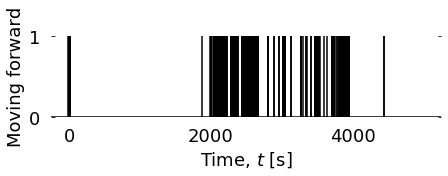

In [89]:
names=["Moving forward"]
fontsize=20
for k in range(0,len(names)):
    gs = gridspec.GridSpec(1,1)
    fig = plt.figure(figsize=(7,1.5))
    
    ax0 = fig.add_subplot(gs[0,0])
    x=np.array(df[["time"]][df.time<5000]).ravel()
    y1=np.array(df[["mov_forward"]][df.time<5000]).ravel()
    ax0.vlines(x, 0, y1, colors='k', linestyles='solid')
    ax0.acorr(x,color='k')
        
    ax0.set_ylim(0,1)
    #ax0.set_xlim(0,2000)
    ax0.locator_params(axis='x',nbins=5)
    ax0.locator_params(axis='y',nbins=1)
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    ax0.spines['left'].set_visible(False)
    
    ax0.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off
    
    ax0.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off
    
    
    
    plt.ylabel("Moving forward") ; plt.xlabel('Time, $t$ [s]') ;

    increase_font(ax0,18)
    

0.793365783126 0.0120222180624


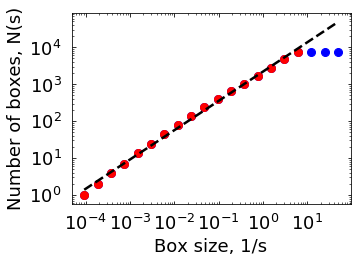

In [90]:
U=timeseriestoeventtimes(df,series)
r, N =nbox_boxsize(U,number_of_sizes=20)
list_df, error_df=find_stable_slope(r,N,3)
drop_last_points=-(len(np.array(list_df)[np.array(list_df)<0.1])+1)
drop_first_points=0
Df, A, r_value, p_value, std_err =fit_data(r[drop_first_points:drop_last_points],N[drop_first_points:drop_last_points])
print(Df,std_err)
fractal_plot(r,N,A,Df,drop_first_points,drop_last_points,series)
plt.show()

In [91]:
U=timeseriestoeventtimes(df,series)
r, N =nbox_boxsize(U,number_of_sizes=20)
list_df, error_df=find_stable_slope(r,N,3)
drop_last_points=-(len(np.array(list_df)[np.array(list_df)<0.1])+1)
drop_first_points=0
Df, A, r_value, p_value, std_err =fit_data(r[drop_first_points:drop_last_points],N[drop_first_points:drop_last_points])
print(Df)

0.793365783126


In [ ]:
age=1
for age in [1,2,3,4,5,6]:
    print(age)
    sample_dir=pathlib.Path('../data/age/{}'.format(age))
    tracks=[i for i in sample_dir.glob('*')]

    df_tracks=[]
    for track in tracks:
        df_track=pd.read_csv(str(track), index_col=0)
        df=df_track[df_track.time>=1800] #Select points with time t>30 minutes
        df.sort_values(by='time',inplace=True)
        if len(df)>100:
            df_tracks.append(df)

    fd_exp=[]
    for track in df_tracks:
        df=track
        series="mov_forward"
        eventtimes = timeseriestoeventtimes(df, series)
        if sum(eventtimes) > 0:
            r, N = nbox_boxsize(eventtimes, number_of_sizes=20)
            if sum(N) > 0:
                list_df, error_df = find_stable_slope(r, N, 3)
                drop_last_points = -(len(np.array(list_df)[np.array(list_df) < 0.1]) + 1)
                drop_first_points = 0
                Df, A, r_value, p_value, std_err = fit_data(
                    r[drop_first_points:drop_last_points],
                    N[drop_first_points:drop_last_points])
                if len(r) > abs(drop_last_points):
                    fd_exp.append(Df)

    data_plot = pd.DataFrame(fd_exp)
    data_plot.to_csv('../results/fd_exp-{}.csv'.format(age), index=False, header=False)


1
2
